# This is our first experiment on sound and music

Today we'll learn how to create a sound on a computer, how we can visualize it, and how we can play it.

First, what is a sound for a computer ?
It's just a sequence of numbers that describe the way "air pressure" is changing with time.
You don't have to know exactly what does it mean, but basically if you create different sequences of numbers, you create different sounds.
Today we'll have a quick look at which sequence of numbers create which sound.

## Let's create our first sounds
The purest sound is called a sinusoid.
You'll recognize it easily in a few moments.

We'll need some tools to create sounds, visualize them and play them.
We will create some python functions to do so.

First, create_sinusoid will do what its name suggest, and plot_sound will allow us to see what the numbers look like.



sound contains : [ 0.          0.06266535  0.12508438  0.18701173  0.24820396  0.30842056
  0.36742481  0.42498479  0.48087423  0.53487345  0.58677018  0.63636043
  0.68344927  0.7278516   0.76939288  0.80790983  0.84325103  0.87527758
  0.90386358  0.92889666  0.95027843  0.96792484  0.98176651  0.99174905
  0.99783321  0.99999508  0.99822617  0.99253341  0.98293919  0.96948123
  0.95221242  0.93120065  0.9065285   0.87829297  0.84660503  0.81158925
  0.77338326  0.73213726  0.68801336  0.64118501  0.59183629  0.54016117
  0.48636278  0.43065259  0.37324958  0.31437941  0.25427347  0.19316803
  0.13130328  0.0689224   0.0062706  -0.05640584 -0.11886057 -0.18084808
 -0.2421247  -0.30244958 -0.36158559 -0.41930028 -0.47536678 -0.5295647
 -0.581681   -0.63151083 -0.6788583  -0.72353732 -0.76537224 -0.80419864
 -0.83986388 -0.87222778 -0.90116312 -0.92655615 -0.94830707 -0.96633038
 -0.98055523 -0.9909257  -0.99740103 -0.99995576 -0.99857987 -0.99327874
 -0.98407323 -0.97099951 -0.9541089

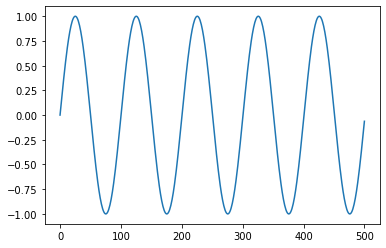

In [1]:
import numpy as np
from matplotlib import pyplot as plt

fs = 44100

def create_sinusoide_sound(frequency, seconds):
    """This will create a sinusoid lasting 'seconds' with the given 'frequency'.
    A frequency of 440 is the A3 note."""
    # Generate array with seconds*sample_rate steps, ranging between 0 and seconds
    t = np.linspace(0, seconds, int(seconds * fs), False)

    # Generate a sine wave
    note = np.sin(frequency * t * 2 * np.pi)
    
    return note

def plot_sound(input_sound):
    plt.plot(input_sound)

# Here we create a short sound, the A note    
sound = create_sinusoide_sound(440, 5 / 440.0)

print("sound contains :", sound)
print("sound contains %d numbers" % len(sound))

# We display it
plot_sound(sound)

Now let's play it, using a new function, play_sound

In [2]:
import simpleaudio as sa
import random
fs = 44100

def play_sound(input_sound):    
    # Ensure that highest value is in 16-bit range
    audio = input_sound * (2**15 - 1) / np.max(np.abs(input_sound))
    # Convert to 16-bit data
    audio = audio.astype(np.int16)

    # Start playback
    play_obj = sa.play_buffer(audio, 1, 2, fs)

    # Wait for playback to finish before exiting
    play_obj.wait_done()
    

# Here we create a longer sound (1 second), the A note    
sound = create_sinusoide_sound(440, 1)
play_sound(sound)

    

What if we change the 440 ? And if we play several notes in sequence ?

In [40]:
sound = create_sinusoide_sound(220, 1)
play_sound(sound)

sound = create_sinusoide_sound(440, 1)
play_sound(sound)

sound = create_sinusoide_sound(880, 1)
play_sound(sound)

In [41]:
sound = create_sinusoide_sound(220, 1)
play_sound(sound)

sound = create_sinusoide_sound(330, 1)
play_sound(sound)

sound = create_sinusoide_sound(440, 1)
play_sound(sound)

In [42]:
frequencies = [220, 280, 330, 440, 880, 660]

for i in range(10):
    f = random.choice(frequencies)
    sound = create_sinusoide_sound(f, 1.0)
    play_sound(sound)


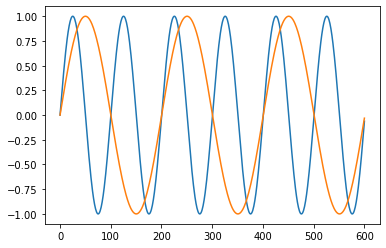

In [46]:
# Here we create a longer sound (1 second), the A note    
sound = create_sinusoide_sound(440, 6 / 440)
plot_sound(sound)

# Here we create a longer sound (1 second), the A note    
sound = create_sinusoide_sound(220, 6 / 440)
plot_sound(sound)

